In [2]:
import os
import sys
os.environ["UW_ENABLE_TIMING"] = "1"
import underworld as uw
from underworld import function as fn
from underworld.scaling import units as u
from underworld.scaling import dimensionalise as dm, non_dimensionalise as nd
import glucifer
import numpy as np

In [3]:
wholeMantleFlag = False
airLayer = True
airHeight = 50.0 * u.kilometer if airLayer else 0.0 * u.kilometer
modelHeight = 2891 * u.kilometer if wholeMantleFlag else 1000.0 * u.kilometer
earthRadius = 6371 * u.kilometer
modelCartAspect = 2 if wholeMantleFlag else 4
ThetaRAD = np.rad2deg((modelHeight * modelCartAspect) / earthRadius)

# plateHeight = 120. * u.kilometer
refDensity = 3200.0 * u.kilogram / u.meter ** 3
deltaRhoMax = 100.0 * u.kilogram / u.meter ** 3
gravity = 9.8 * u.metre / u.second ** 2
# 1.57e20 * u.pascal * u.second 5.e20 * u.pascal * u.second
refViscosity = 5.0e20 * u.pascal * u.second
bodyForce = refDensity * gravity

# scaling coefficients
K_eta = refViscosity
KL = modelHeight
K_tau = bodyForce * modelHeight
K_v = K_tau * modelHeight / K_eta
# Kt = KL/K_v
Kt = K_eta / K_tau
KM = K_tau * modelHeight * Kt ** 2

scaling_coefficients = uw.scaling.get_coefficients()

scaling_coefficients["[length]"] = KL.to_base_units()
# scaling_coefficients["[temperature]"] = KT.to_base_units()
scaling_coefficients["[time]"] = Kt.to_base_units()
scaling_coefficients["[mass]"] = KM.to_base_units()


In [4]:
step=0
time=0.
maxSteps=1
outputDir='AnnSubBenchmark'

In [5]:
nd((3200.*u.kilogram/u.meter**3)*gravity)

1.0000000000000002

In [6]:
mesh = uw.mesh.FeMesh_Annulus(
        elementRes = (128,256),
        radialLengths = (nd(earthRadius-modelHeight+airHeight),nd(earthRadius)),
        angularExtent=((180-ThetaRAD.magnitude)/2,90+ThetaRAD.magnitude/2),
        periodic=[False,False]
)
        


velocityField       = mesh.add_variable( nodeDofCount=2 )
pressureField       = mesh.subMesh.add_variable( nodeDofCount=1 )
lower = mesh.specialSets["MinI_VertexSet"]
upper = mesh.specialSets["MaxI_VertexSet"]
swarm = uw.swarm.Swarm(mesh, particleEscape=True)
materialVariable=swarm.add_variable(count=1,dataType="int")
layout = uw.swarm.layouts.PerCellSpaceFillerLayout(swarm, particlesPerCell=10)
swarm.populate_using_layout(layout)
advector = uw.systems.SwarmAdvector(velocityField=velocityField, swarm=swarm)

In [7]:
I = mesh.specialSets["inner"]
O = mesh.specialSets["outer"]
# W = mesh.specialSets["Left_VertexSet"]
# E = mesh.specialSets["Right_VertexSet"]
S = mesh.specialSets["MinJ_VertexSet"]
N = mesh.specialSets["MaxJ_VertexSet"]

# allWalls = mesh.specialSets["AllWalls_VertexSet"]
# NS0 = N+S-(E+W)
# # build corner edges node indexset
# cEdge = (N&W)+(N&E)+(S&E)+(S&W)

In [25]:
upperSurf = mesh.specialSets["upper_surface_VertexSet"]
lowerSurf = mesh.specialSets["lower_surface_VertexSet"]
rightSide = mesh.specialSets["MinJ_VertexSet"]
leftSide = mesh.specialSets["MaxJ_VertexSet"]
cornEdge = (upper&rightSide) + (upper&leftSide) + (lowerSurf&rightSide) +(lowerSurf&leftSide)
# rightWall = mesh.specialSets["Right_VertexSet"]
# leftWall = mesh.specialSets["Left_VertexSet"]
# freeslipBC = uw.conditions.DirichletCondition(
#     variable=velocityField, indexSetsPerDof=(iWalls, jWalls)
# )

# cEdge = 
def setVbc():
    velocityField.data[...] = 0.0
    velocityField.data[upperSurf.data, :] = (0.0, 0.0)
    velocityField.data[lowerSurf.data, :] = (0.0, 0.0)
    velocityField.data[leftSide.data, :] = (1000.0, 1000.0)
    velocityField.data[rightSide.data, :] = (1000.0, 1000.0)
    velocityField.data[cornEdge.data]=(0.0,0.0)

setVbc()
freeSlipAn = uw.conditions.RotatedDirichletCondition(
    variable=velocityField,
    indexSetsPerDof=(upperSurf + lowerSurf, rightSide + leftSide),
    basis_vectors=(mesh.bnd_vec_normal, mesh.bnd_vec_tangent),
)

In [9]:
np.rad2deg(min(mesh.thetaFn.evaluate(swarm.data)))

array([ 72.01370511])

In [10]:
mesh.specialSets.keys()

dict_keys(['MaxJ_VertexSet', 'inner', 'AllWalls_VertexSet', 'Top_VertexSet', 'upper_surface_VertexSet', 'outer', 'excluded_VertexSet', 'surfaces_e2_normal_VertexSet', 'Empty', 'Left_VertexSet', 'lower_surface_VertexSet', 'surfaces_e1_normal_VertexSet', 'Right_VertexSet', 'vertical_surfaces_VertexSet', 'Bottom_VertexSet', 'surfaces_e3_normal_VertexSet', 'MinJ_VertexSet', 'MaxI_VertexSet', 'MinI_VertexSet'])


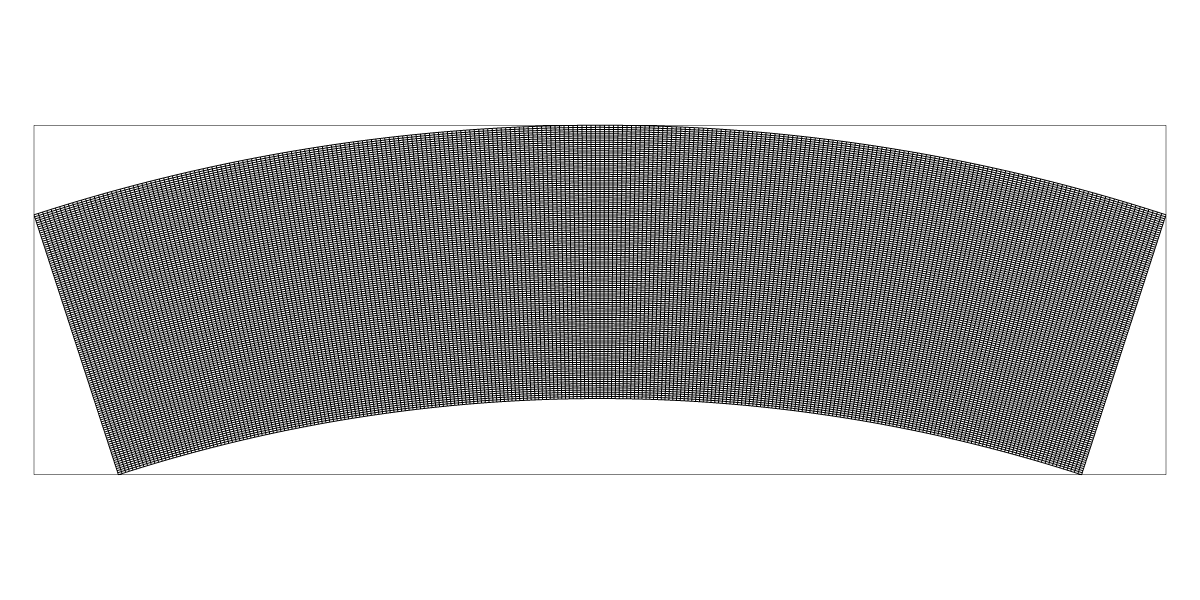

In [11]:
store=None
fig = glucifer.Figure(store=store,figsize=(1200,600))
# fig.append( glucifer.objects.Mesh( mesh ,nodeNumbers=True))
fig.append( glucifer.objects.Mesh( mesh ))
# fig.append( glucifer.objects.Points( swarm,pointsize=4))
fig.show()

In [12]:
radialFn = fn.math.sqrt(fn.math.dot(fn.coord(), fn.coord()))
thetaFn = fn.math.atan2(fn.coord()[1], fn.coord()[0])


In [13]:
class Annulus(fn.Function):
    """Annulus"""

    def __init__(self, c1,c2, r1, r2):
        """Create an Annulus shape
        Parameters
        ----------
        center : center of the annulus
        r1 : Internal radius
        r2 : External radius
        Returns
        -------
        An UWGeodynamics Shape object
        """
        self.r1 = r1
        self.r2 = r2


        
        coord1 = fn.input() - c1
        coord2 = fn.input() - c2
        self._fn = (fn.math.dot(coord2, coord2) < r2**2) & (fn.math.dot(coord1, coord1) > r1**2)
        super(Annulus, self).__init__(argument_fns=None)
        self._fncself = self._fn._fncself

In [14]:
rp=nd(earthRadius- airHeight)
dip=29
theta=0
rE=nd(rp)/np.cos(np.deg2rad(dip))
cE=(rp*np.tan(np.deg2rad(dip))*-np.sin(np.deg2rad(theta-90)),rp*np.tan(np.deg2rad(dip))*np.sin(np.deg2rad(theta)))
rp=nd(earthRadius-100.*u.kilometer- airHeight)
dip=29
theta=0
rI=nd(rp)/np.cos(np.deg2rad(dip))
cI=(rp*np.tan(np.deg2rad(dip))*-np.sin(np.deg2rad(theta-90)),rp*np.tan(np.deg2rad(dip))*np.sin(np.deg2rad(theta)))
perturb=(Annulus(cI,cE,rI,rE).evaluate(swarm)) & (mesh.thetaFn.evaluate(swarm)<np.deg2rad(92.1))


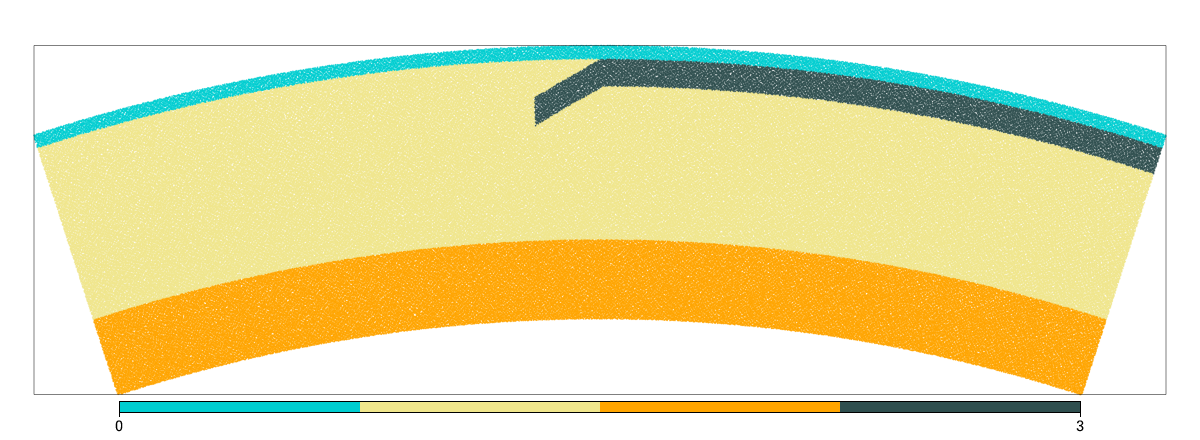

In [16]:
re=np.radians(.1+(180-ThetaRAD.magnitude)/2)
air = mesh.unit_heightFn.evaluate(swarm.data) > nd(modelHeight - airHeight)
lowermantle = mesh.unit_heightFn.evaluate(swarm.data) < nd(
    modelHeight - airHeight - 660.0 * u.kilometer
)
slab = (
    (mesh.unit_heightFn.evaluate(swarm.data) < nd(modelHeight - airHeight))
    & (
        mesh.unit_heightFn.evaluate(swarm.data)
        > nd(modelHeight - airHeight - 100.0 * u.kilometer)
    )
    & (mesh.thetaFn.evaluate(swarm.data) <= np.pi / 2)

)
# perturb = (
#     (mesh.unit_heightFn.evaluate(swarm.data) < nd(modelHeight - airHeight))
#     & (
#         mesh.unit_heightFn.evaluate(swarm.data)
#         > nd(modelHeight - airHeight - 200.0 * u.kilometer)
#     )
#     & (mesh.thetaFn.evaluate(swarm.data) <= np.pi / 2)
# )

materialVariable.data[:]=1

materialVariable.data[lowermantle]=2
materialVariable.data[slab]=3
materialVariable.data[perturb]=3
materialVariable.data[air]=0
store=None
figP = glucifer.Figure(store=store,figsize=(1200,440))
# fig.append( glucifer.objects.Mesh( mesh))
figP.append( glucifer.objects.Points( swarm,materialVariable,colours='#00CED1 #F0E68C #FFA500 #2F4F4F',pointsize=2,discrete=True))
figP.show()

In [17]:
nd(earthRadius)

6.3709999999999996


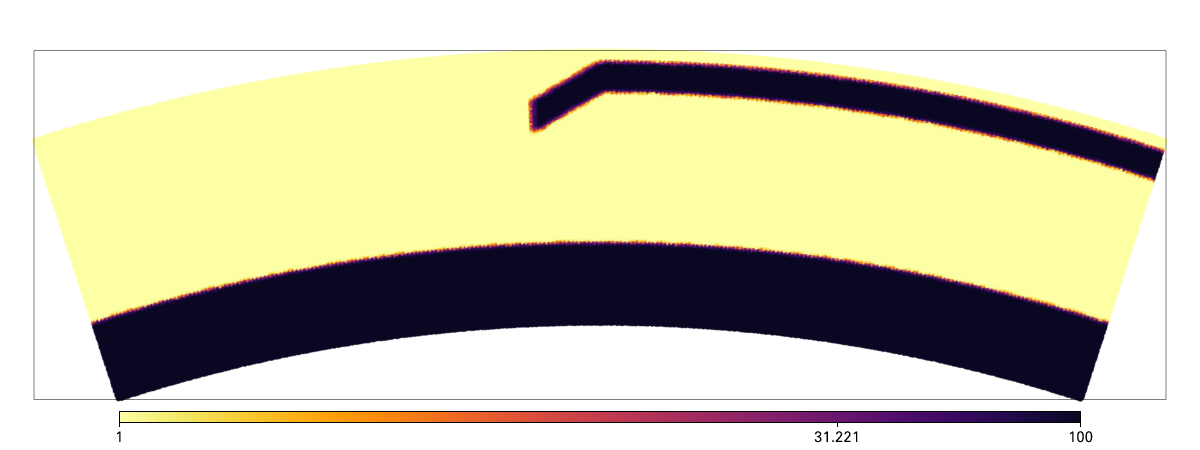

In [26]:
airViscosity = 1.0
mantleViscosity = 1.0
lowermantleViscosity = 1e2
slabViscosity = 1e2
viscosityMap = {
    0: airViscosity,
    1: mantleViscosity,
    2: lowermantleViscosity,
    3: slabViscosity,
}
swarmviscosityFn = fn.branching.map(fn_key=materialVariable, mapping=viscosityMap)

viscosityFn = mesh.add_variable(1)
projVisMesh = uw.utils.MeshVariable_Projection(viscosityFn, swarmviscosityFn, type=0)
projVisMesh.solve()

figV = glucifer.Figure(store=store, figsize=(1200, 450))
# fig.append( glucifer.objects.Mesh( mesh))
figV.append(
    glucifer.objects.Points(
        swarm,
        viscosityFn,
        pointsize=5,
        logScale=True,
        colours=glucifer.lavavu.matplotlib_colourmap("inferno_r"),
    )
)

figV.show()

In [27]:
def checkpoint(mesh,fieldDict,swarm,swarmDict,index,modeltime=None,meshName="mesh",swarmName="swarm",prefix="./",enable_xdmf=True,):
    # Check the prefix is valid
    if prefix is not None:
        if not prefix.endswith("/"):
            prefix += "/"  # add a backslash
        if not os.path.exists(prefix) and uw.mpi.rank == 0:
            print("Creating directory: ", prefix)
            os.makedirs(prefix)

    uw.mpi.barrier()

    if not isinstance(index, int):
        raise TypeError("'index' is not of type int")
    if modeltime is not None:
        time = modeltime
    else:
        time = index

    ii = str(index).zfill(5)

    if mesh is not None:

        # Error check the mesh and fields
        if not isinstance(mesh, uw.mesh.FeMesh):
            raise TypeError("'mesh' is not of type uw.mesh.FeMesh")
        if not isinstance(fieldDict, dict):
            raise TypeError("'fieldDict' is not of type dict")
        for key, value in fieldDict.items():
            if not isinstance(value, uw.mesh.MeshVariable):
                raise TypeError(
                    "'fieldDict' must contain uw.mesh.MeshVariable elements"
                )

        # see if we have already saved the mesh. It only needs to be saved once
        if not hasattr(checkpoint, "mH"):
            checkpoint.mH = mesh.save(prefix + meshName + ".h5")
        mh = checkpoint.mH

        for key, value in fieldDict.items():
            filename = prefix + key + "-" + ii
            handle = value.save(filename + ".h5")
            if enable_xdmf:
                value.xdmf(filename, handle, key, mh, meshName, modeltime=time)

    # is there a swarm
    if swarm is not None:

        # Error check the swarms
        if not isinstance(swarm, uw.swarm.Swarm):
            raise TypeError("'swarm' is not of type uw.swarm.Swarm")
        if not isinstance(swarmDict, dict):
            raise TypeError("'swarmDict' is not of type dict")
        for key, value in swarmDict.items():
            if not isinstance(value, uw.swarm.SwarmVariable):
                raise TypeError(
                    "'fieldDict' must contain uw.swarm.SwarmVariable elements"
                )

        sH = swarm.save(prefix + swarmName + "-" + ii + ".h5")
        for key, value in swarmDict.items():
            filename = prefix + key + "-" + ii
            handle = value.save(filename + ".h5")
            if enable_xdmf:
                value.xdmf(filename, handle, key, sH, swarmName, modeltime=time)

In [28]:
airDensity=0.
mantleDensity=0.
slabDensity=1.
densityMap = { 0 : airDensity,
               1 : mantleDensity, 
               2 : mantleDensity, 
               3 : slabDensity}
densityFn = fn.branching.map( fn_key = materialVariable, mapping = densityMap )
buoyancyFn = -1.0 * densityFn * mesh.unitvec_r_Fn


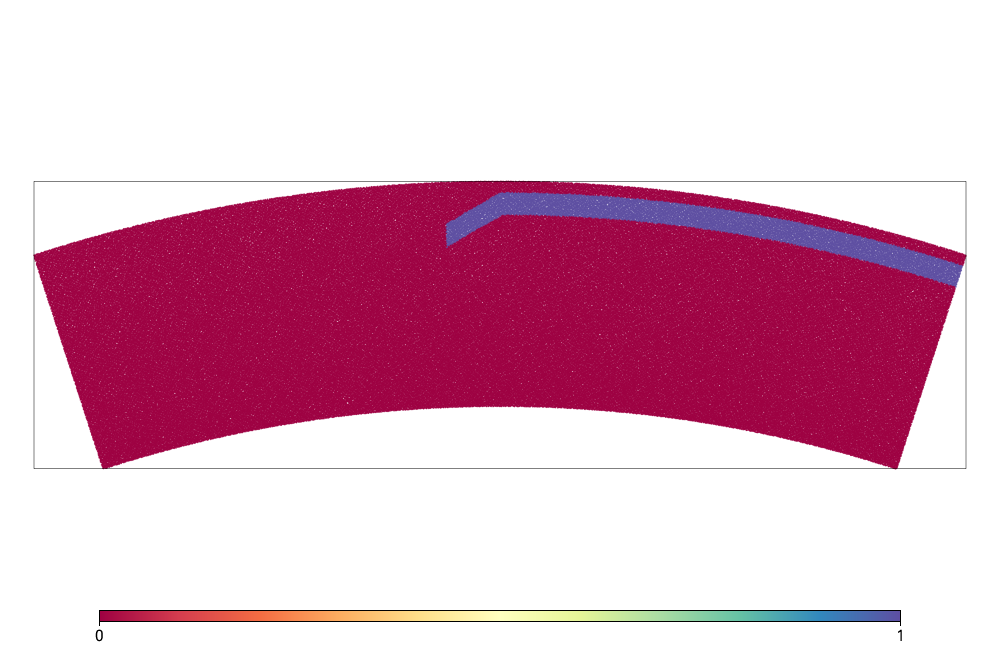

In [29]:
figD = glucifer.Figure(store=store,figsize=(1000,650))
# fig.append( glucifer.objects.Mesh( mesh))
figD.append( glucifer.objects.Points( swarm,densityFn,colours='spectral',pointsize=2))
figD.show()


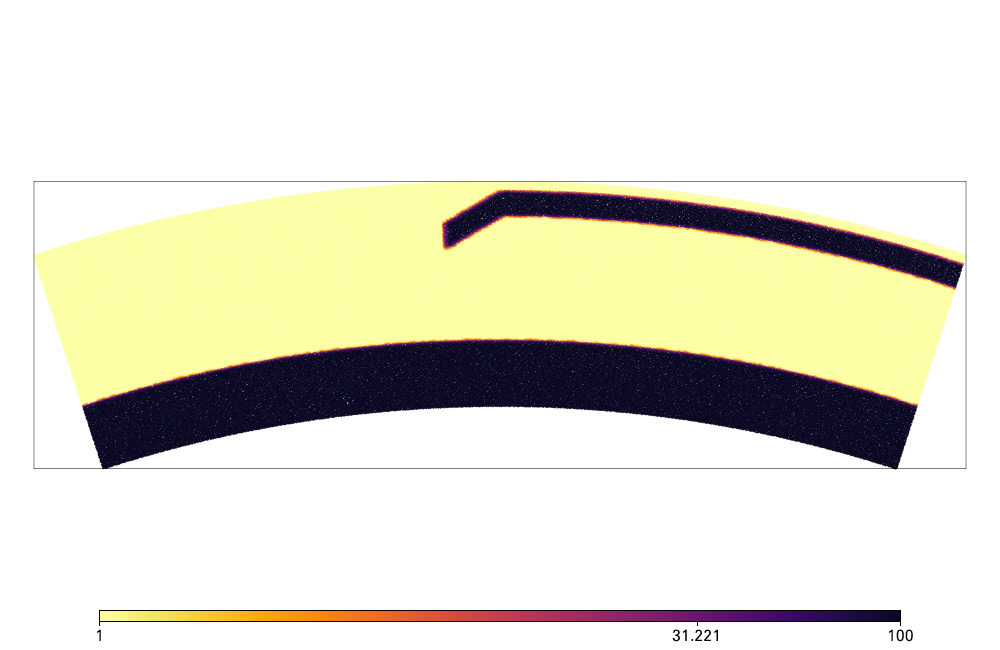

In [30]:
figV = glucifer.Figure(store=store,figsize=(1000,650))
# fig.append( glucifer.objects.Mesh( mesh))
figV.append( glucifer.objects.Points( swarm,viscosityFn,pointsize=2,logScale=True,colours=glucifer.lavavu.matplotlib_colourmap('inferno_r')))
figV.show()

In [31]:
fieldDict = {
    "velocity": velocityField,
    "pressure": pressureField,
#     "meshViscosity": projVisc,
}

swarmDict = {"materials": materialVariable}
# traceDict = {"tcoords": tincord, "tvel": tracerVelocity}

In [32]:
checkpoint(
        mesh,
        fieldDict,
        swarm,
        swarmDict,
        index=step,
        modeltime=dm(time, 1.0 * u.megayear).magnitude,
        prefix=outputDir,
    )

In [33]:
stokesSLE = uw.systems.Curvilinear_Stokes( velocityField, pressureField, 
                                               fn_viscosity=viscosityFn, 
                                               fn_bodyforce=buoyancyFn,
                                               conditions=freeSlipAn,
                                              _removeBCs=False)

In [34]:
stokesSolverAN = uw.systems.Solver(stokesSLE)

stokesSolverAN.options.A11.ksp_type="fgmres"
stokesSolverAN.options.scr.ksp_rtol=1.0e-4
stokesSolverAN.options.scr.ksp_max_it=100
stokesSolverAN.options.scr.ksp_monitor="ascii"
stokesSolverAN.options.scr.ksp_type="fgmres"
stokesSolverAN.options.A11.ksp_rtol=1.0e-5
stokesSolverAN.options.A11.ksp_monitor="ascii"

stokesSolverAN.set_penalty(10.0)
stokesSolverAN.options.main.restore_K=True
stokesSolverAN.options.main.force_correction=True
stokesSolverAN.options.main.Q22_pc_type="gkgdiag"

stokesSolverAN.options.mg_accel.mg_accelerating_smoothing=True
stokesSolverAN.options.mg_accel.mg_smooths_to_start=3
stokesSolverAN.options.mg_accel.mg_smooths_max=10
stokesSolverAN.options.mg.mg_levels_ksp_convergence_test='skip'
stokesSolverAN.options.mg.mg_levels_ksp_norm_type='none'
stokesSolverAN.options.mg.mg_levels_ksp_max_it=5
stokesSolverAN.options.mg.mg_levels_ksp_type="chebyshev"
stokesSolverAN.options.mg.mg_coarse_pc_type="lu"
stokesSolverAN.options.mg.mg_coarse_pc_factor_mat_solver_package="mumps"

In [35]:
# stokesSolverAN.solve(print_stats=True, reinitialise=True)

In [36]:
# uw.libUnderworld.Underworld.AXequalsX( stokesSLE_AN._rot._cself, stokesSLE_AN._velocitySol._cself, False)

In [37]:
def postSolve():
    # realign solution
    uw.libUnderworld.Underworld.AXequalsX( stokesSLE._rot._cself, stokesSLE._velocitySol._cself, False)
    # remove null space
    uw.libUnderworld.StgFEM.SolutionVector_RemoveVectorSpace(stokesSLE._velocitySol._cself, stokesSLE._vnsVec._cself)

In [300]:
advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )

In [38]:
maxSteps=100
while step<maxSteps:
    velocityField.data[:] = 0.
    setVbc()
    stokesSolverAN.solve(callback_post_solve=postSolve)
    dt=advector.get_max_dt()
    advector.integrate(dt)
    step+=1
    time+=dt
    checkpoint(
        mesh,
        fieldDict,
        swarm,
        swarmDict,
        index=step,
        modeltime=dm(time, 1.0 * u.megayear).magnitude,
        prefix=outputDir,
    )

RuntimeError: Issue utilising function of class 'SwarmVariable' constructed at:
    Line 15 of notebook cell 6:
       materialVariable=swarm.add_variable(count=1,dataType="int")

Error message:
Error occurred while trying to evaluate swarm variable. This can occur when there are no particles found in a given element. You may wish to add population control mechanisms. Please contact developers if this does not appear to be the issue.

In [306]:
stokesSLE = uw.systems.Curvilinear_Stokes

In [4]:
uw.libUnderworld.Underworld.AXequalsY??

In [302]:
figVdot = glucifer.Figure(store=store, figsize=(1200, 450))
figVdot.append(
    glucifer.objects.Surface(
        mesh,
        fn.math.dot(velocityField, velocityField),
        # logScale=True,
        colours=glucifer.lavavu.matplotlib_colourmap("viridis"),
    )
)


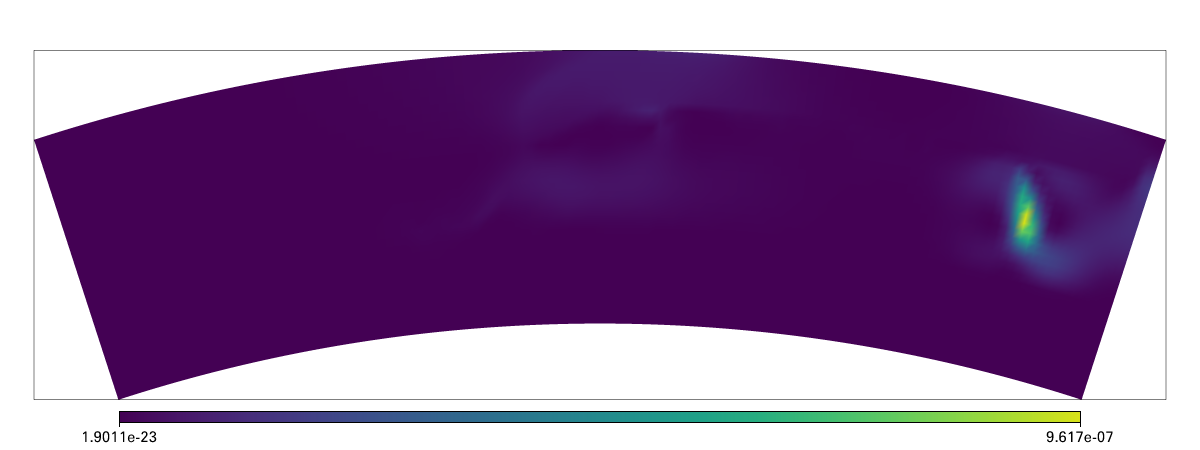

In [307]:
figVdot.show()


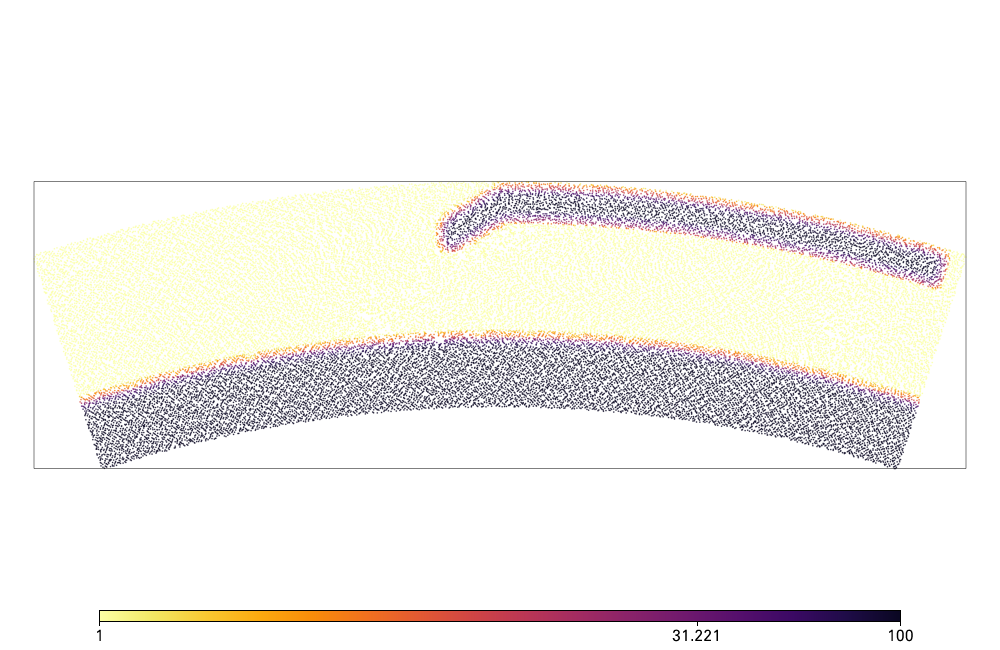

In [311]:
figV.show()


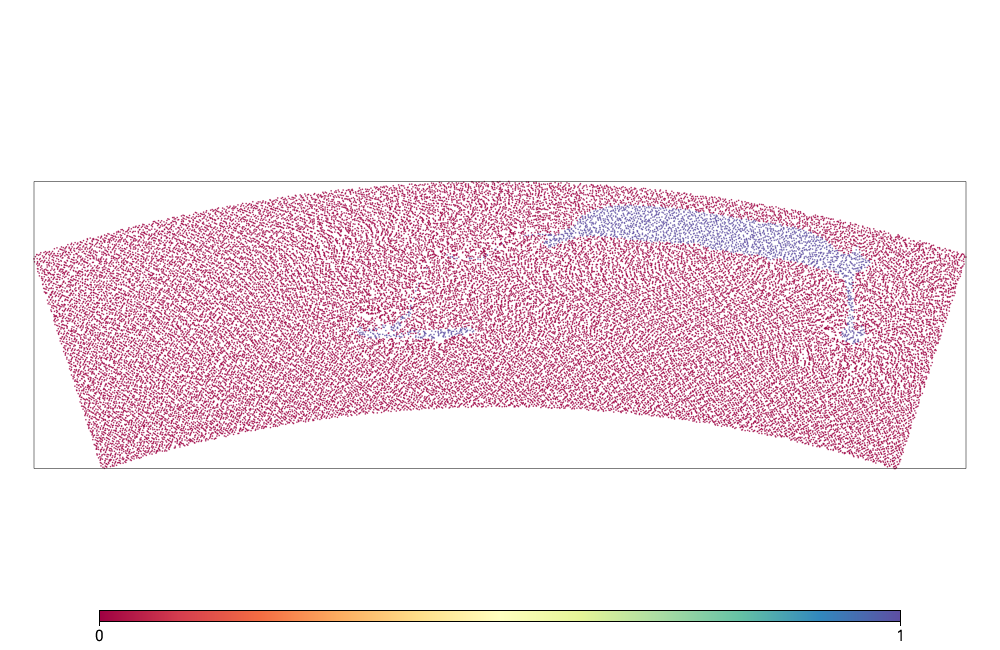

In [312]:
figD.show()


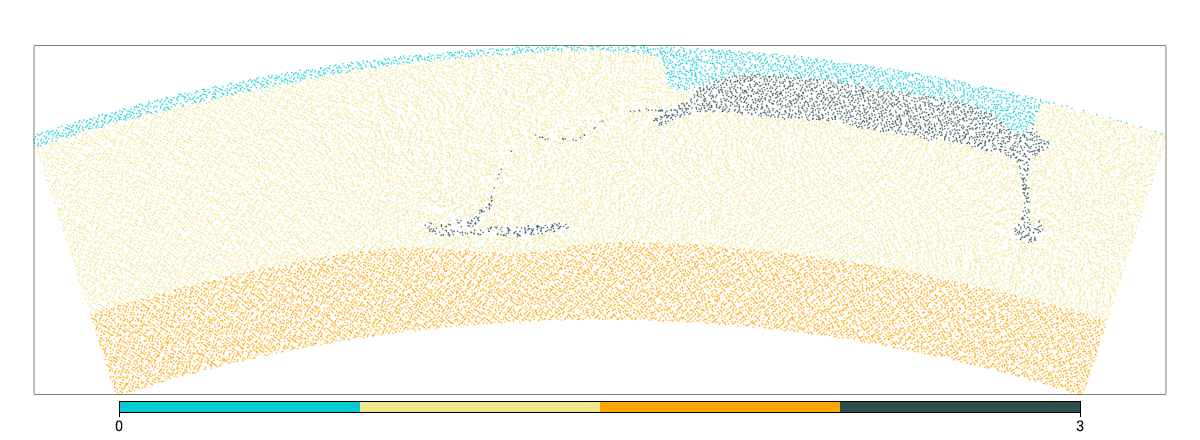

In [313]:
figP.show()